In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [3]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [4]:
pd.set_option('display.max_colwidth', None)

In [2]:
# Force garbage collection
import gc
gc.collect()

0

In [7]:
all_features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020.parquet')

In [6]:
all_features.shape

(128056650, 22)

In [7]:
all_features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi_pre_interpolated                               float32
pdsi_class                                          float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

In [8]:
all_features['wind_direction_category'].value_counts()

wind_direction_category
W     24404776
SW    22192376
NW    21750021
S     20081161
SE    14517972
N      9048449
E      7686416
NE     7026055
Name: count, dtype: int64

In [9]:
wind_direction_ranges = {
    'N': (337.5, 22.5),
    'NE': (22.5, 67.5),
    'E': (67.5, 112.5),
    'SE': (112.5, 157.5),
    'S': (157.5, 202.5),
    'SW': (202.5, 247.5),
    'W': (247.5, 292.5),
    'NW': (292.5, 337.5)
}

In [10]:
# Initialize the wind_direction_category column with None
all_features['wind_direction_category'] = None

# Use numpy to create boolean masks for each wind direction category
wind_from_direction = all_features['wind_from_direction'].values

# Mask for North (N)
mask_N = (wind_from_direction >= 337.5) | (wind_from_direction < 22.5)
all_features.loc[mask_N, 'wind_direction_category'] = 'N'

# Masks for other directions
for category, (min_angle, max_angle) in wind_direction_ranges.items():
    if category != 'N':
        mask = (wind_from_direction >= min_angle) & (wind_from_direction < max_angle)
        all_features.loc[mask, 'wind_direction_category'] = category

In [11]:
# order the wind_direction_category from N to NW
wind_direction_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
all_features['wind_direction_category'] = pd.Categorical(all_features['wind_direction_category'], categories=wind_direction_order, ordered=True)

In [12]:
all_features['wind_direction_category'].value_counts()

wind_direction_category
NW    28004942
SW    22612683
W     20820438
S     17290211
N     12892006
SE    10482424
NE     8032627
E      6571895
Name: count, dtype: int64

In [13]:
all_features.shape

(128056650, 22)

In [15]:
all_features['Band1'] = all_features['Band1'].fillna(0)

In [16]:
# write it back to parquet file
output_file = f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020.parquet'
all_features.to_parquet(output_file)

In [85]:
import gc
gc.collect()

0

In [7]:
all_features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020.parquet')

In [8]:
# check missing values
all_features.isnull().sum()

lon                                                0
lat                                                0
day                                                0
dead_fuel_moisture_1000hr                    1190715
dead_fuel_moisture_100hr                     1190715
pdsi_pre_interpolated                         321420
pdsi_class                                   1512135
max_air_temperature                                0
max_relative_humidity                        1190715
max_wind_speed                               1260183
min_air_temperature                                0
min_relative_humidity                        1190717
precipitation_amount                               0
specific_humidity                            1190715
surface_downwelling_shortwave_flux_in_air    1190715
wind_from_direction                          1349424
wind_speed                                   1190715
wind_direction_category                      1349424
SWE                                           

In [ ]:
col_to_fill = ['dead_fuel_moisture_1000hr','dead_fuel_moisture_100hr',
               'max_relative_humidity', 'min_relative_humidity','specific_humidity','surface_downwelling_shortwave_flux_in_air',
               'max_wind_speed','wind_speed',
               'wind_from_direction','wind_direction_category',
               'LAI',
               'pdsi']

In [79]:
# fill 0 to missing in LAI
all_features['LAI'] = all_features['LAI'].fillna(0)

col_missing = ['dead_fuel_moisture_1000hr','dead_fuel_moisture_100hr',
               'max_relative_humidity', 'min_relative_humidity','specific_humidity','surface_downwelling_shortwave_flux_in_air',
               'max_wind_speed','wind_speed',
               'wind_from_direction','wind_direction_category',
               'LAI',
               'pdsi']
# for col in col_missing, remove the rows with missing values
for col in col_missing:
    all_features = all_features[all_features[col].notna()]
    print(f"Missing values in {col}: {all_features[col].isna().sum()}")

Missing values in dead_fuel_moisture_1000hr: 0
Missing values in dead_fuel_moisture_100hr: 0
Missing values in max_relative_humidity: 0
Missing values in min_relative_humidity: 0
Missing values in specific_humidity: 0
Missing values in surface_downwelling_shortwave_flux_in_air: 0
Missing values in max_wind_speed: 0
Missing values in wind_speed: 0
Missing values in wind_from_direction: 0
Missing values in wind_direction_category: 0
Missing values in LAI: 0
Missing values in pdsi: 0


In [80]:
all_features.isnull().sum()

lon                                          0
lat                                          0
day                                          0
dead_fuel_moisture_1000hr                    0
dead_fuel_moisture_100hr                     0
pdsi_pre_interpolated                        0
pdsi_class                                   0
max_air_temperature                          0
max_relative_humidity                        0
max_wind_speed                               0
min_air_temperature                          0
min_relative_humidity                        0
precipitation_amount                         0
specific_humidity                            0
surface_downwelling_shortwave_flux_in_air    0
wind_from_direction                          0
wind_speed                                   0
wind_direction_category                      0
SWE                                          0
Band1                                        0
LAI                                          0
pdsi         

In [ ]:
all_features.shape # old one: 128,056,650

(126317000, 22)

In [83]:
# write it back to parquet file
output_file = f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_Completed_2001_2020.parquet'
all_features.to_parquet(output_file)

Missing value check / analysis before fill in or remove

LAI

In [9]:
# only keep rows when wind_speed is missing
missing_dat = all_features[all_features['LAI'].isnull()]
# only keep column lon, lat, wind_speed
missing_dat = missing_dat[['lon', 'lat', 'day', 'LAI']]
# add column month and year
missing_dat['month'] = missing_dat['day'].dt.month
missing_dat['year'] = missing_dat['day'].dt.year
# randomly fill in LAI
missing_dat['LAI'] = np.random.uniform(low=0, high=5, size=len(missing_dat))

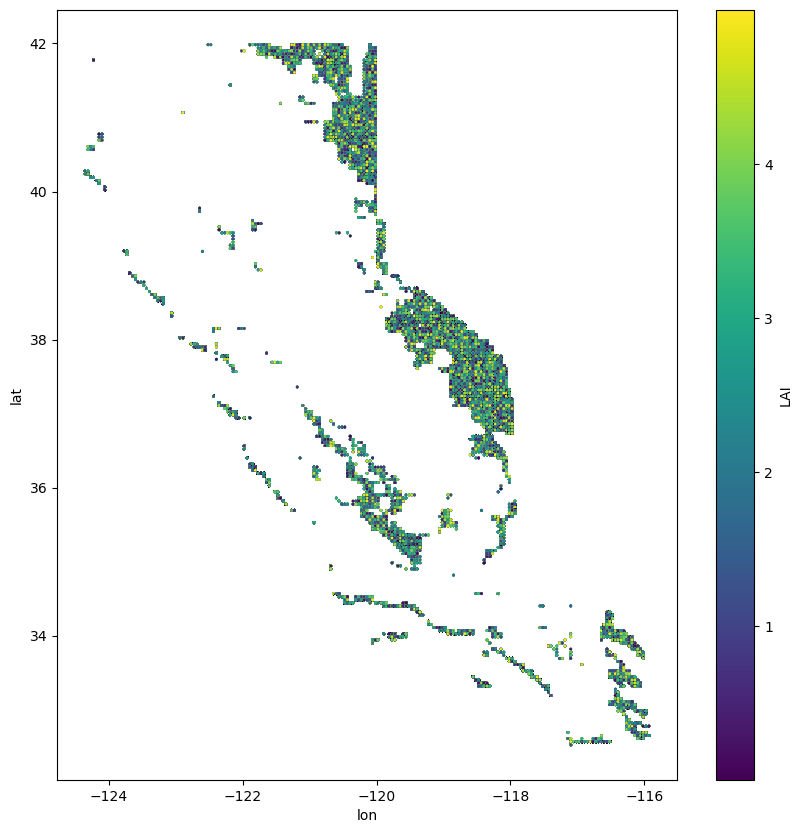

In [10]:
missing_dat.plot(kind='scatter', x='lon', y='lat', c='LAI', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

Confirmed that those missing area can be filled using 0

PDSI

In [11]:
# only keep rows when wind_speed is missing
missing_dat = all_features[all_features['pdsi'].isnull()]
# only keep column lon, lat, wind_speed
missing_dat = missing_dat[['lon', 'lat', 'day', 'pdsi']]
# add column month and year
missing_dat['month'] = missing_dat['day'].dt.month
missing_dat['year'] = missing_dat['day'].dt.year
# randomly fill in LAI
missing_dat['pdsi'] = np.random.uniform(low=0, high=5, size=len(missing_dat))

In [13]:
# check unique values in month
missing_dat['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [14]:
# check unique values in year
missing_dat['year'].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

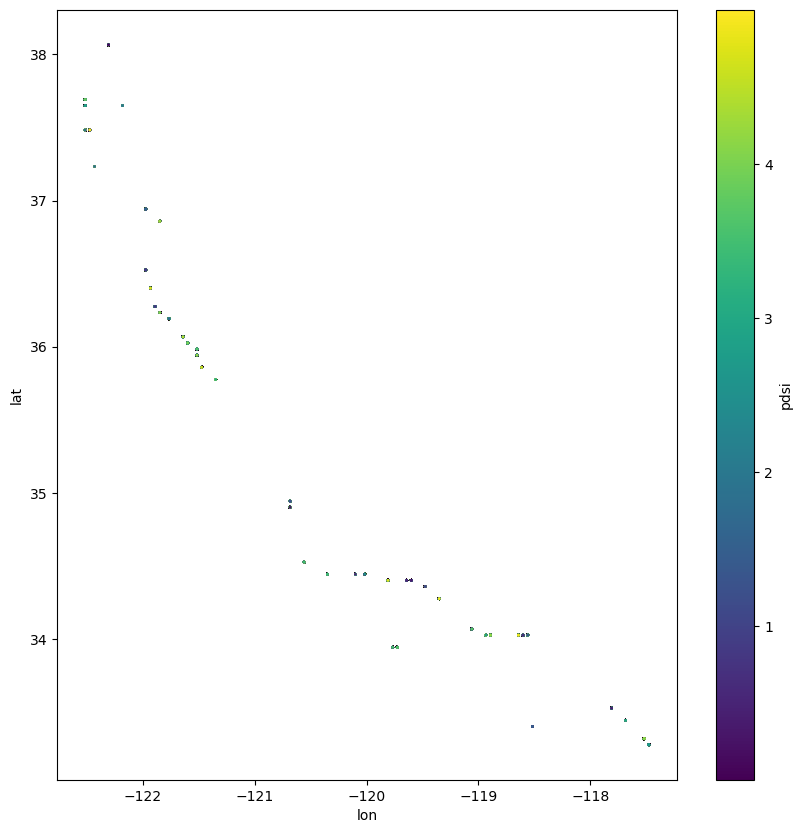

In [12]:
missing_dat.plot(kind='scatter', x='lon', y='lat', c='pdsi', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

dead_fuel_moisture_1000hr

In [15]:
# only keep rows when wind_speed is missing
missing_dat = all_features[all_features['dead_fuel_moisture_1000hr'].isnull()]
# only keep column lon, lat, wind_speed
missing_dat = missing_dat[['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr']]
# add column month and year
missing_dat['month'] = missing_dat['day'].dt.month
missing_dat['year'] = missing_dat['day'].dt.year
# randomly fill in LAI
missing_dat['dead_fuel_moisture_1000hr'] = np.random.uniform(low=0, high=5, size=len(missing_dat))

In [17]:
# check unique values in month
missing_dat['month'].unique(), missing_dat['year'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]))

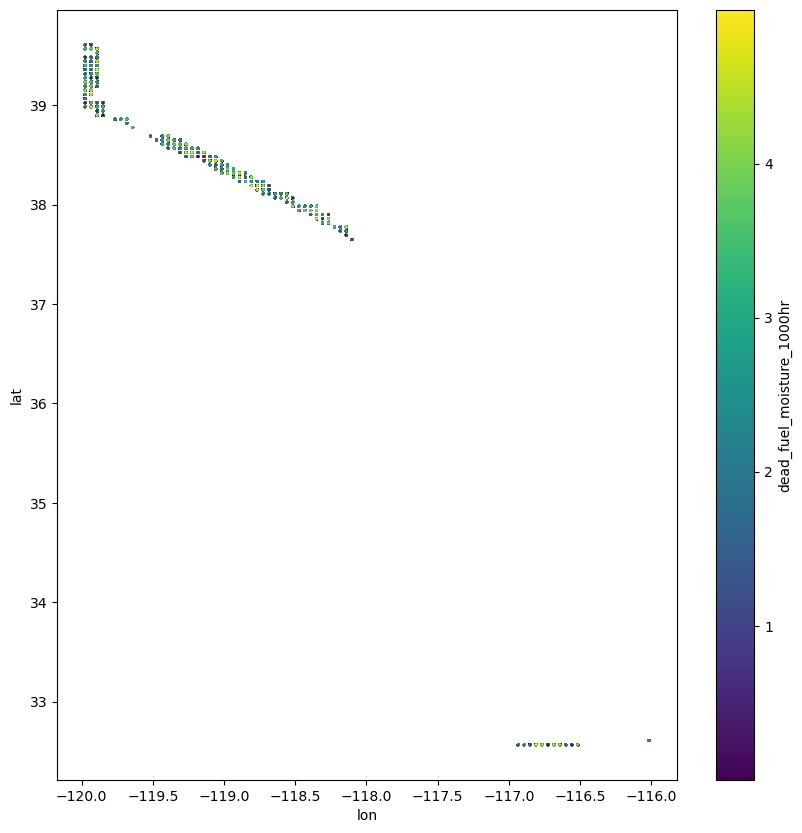

In [18]:
missing_dat.plot(kind='scatter', x='lon', y='lat', c='dead_fuel_moisture_1000hr', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

max_relative_humidity

In [ ]:
col_to_fill = ['max_wind_speed','wind_speed',
               'wind_from_direction','wind_direction_category',]

In [19]:
# only keep rows when wind_speed is missing
missing_dat = all_features[all_features['max_relative_humidity'].isnull()]
# only keep column lon, lat, wind_speed
missing_dat = missing_dat[['lon', 'lat', 'day', 'max_relative_humidity']]
# add column month and year
missing_dat['month'] = missing_dat['day'].dt.month
missing_dat['year'] = missing_dat['day'].dt.year
# randomly fill in LAI
missing_dat['max_relative_humidity'] = np.random.uniform(low=0, high=5, size=len(missing_dat))

In [21]:
# check unique values in month
missing_dat['month'].unique(), missing_dat['year'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]))

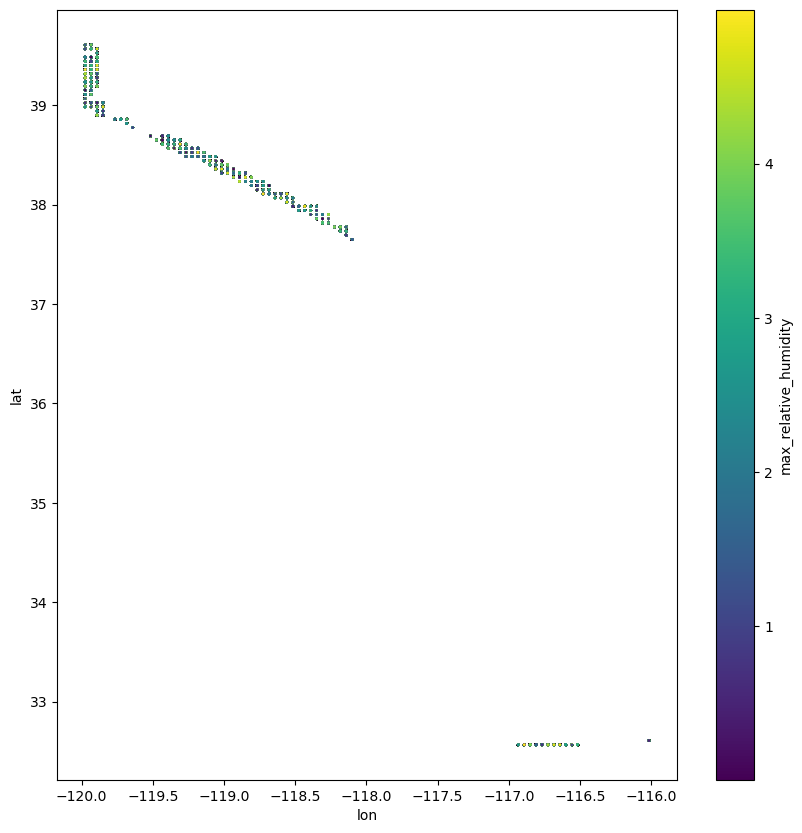

In [22]:
missing_dat.plot(kind='scatter', x='lon', y='lat', c='max_relative_humidity', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

wind_speed

In [23]:
# only keep rows when wind_speed is missing
missing_dat = all_features[all_features['wind_speed'].isnull()]
# only keep column lon, lat, wind_speed
missing_dat = missing_dat[['lon', 'lat', 'day', 'wind_speed']]
# add column month and year
missing_dat['month'] = missing_dat['day'].dt.month
missing_dat['year'] = missing_dat['day'].dt.year
# randomly fill in LAI
missing_dat['wind_speed'] = np.random.uniform(low=0, high=5, size=len(missing_dat))

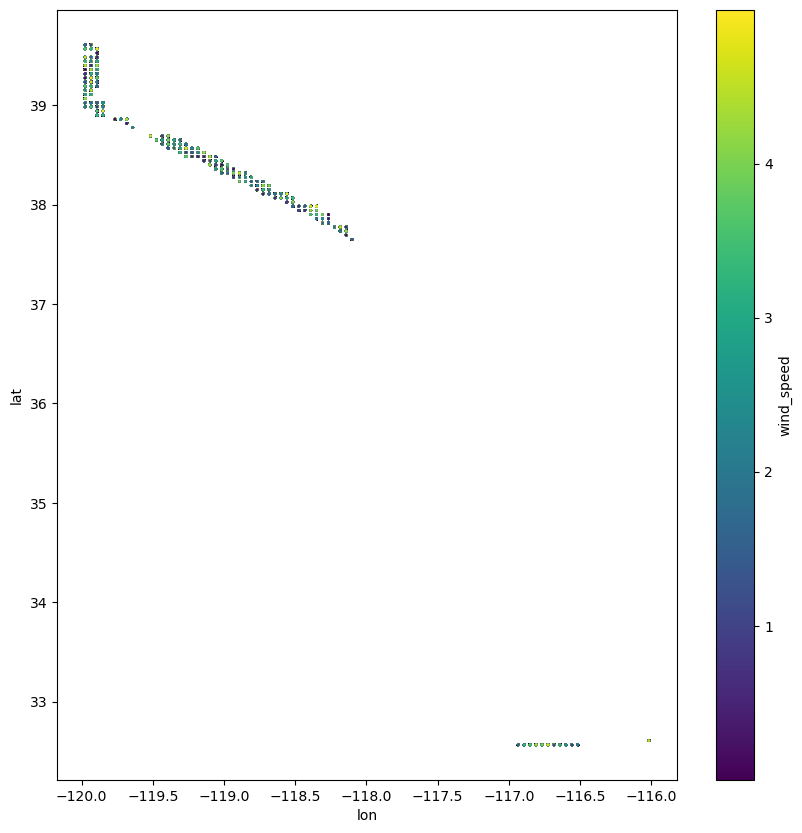

In [24]:
missing_dat.plot(kind='scatter', x='lon', y='lat', c='wind_speed', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

In [25]:
# check unique values in month
missing_dat['month'].unique(), missing_dat['year'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]))

wind_from_direction

In [72]:
# only keep rows when wind_speed is missing
missing_dat = all_features[all_features['wind_from_direction'].isnull()]
# only keep column lon, lat, wind_speed
missing_dat = missing_dat[['lon', 'lat', 'day', 'wind_from_direction','wind_speed']]
# add column month and year
missing_dat['month'] = missing_dat['day'].dt.month
missing_dat['year'] = missing_dat['day'].dt.year
# randomly fill in LAI
#missing_dat['wind_from_direction'] = np.random.uniform(low=0, high=360, size=len(missing_dat))

In [78]:
missing_dat[missing_dat['day']=='2012-12-31']

,lon,lat,day,wind_from_direction,wind_speed,month,year
4382,-124.391667,40.441667,2012-12-31,NaN,3.3,12,2012
11687,-124.391667,40.400000,2012-12-31,NaN,3.2,12,2012
18992,-124.350000,40.566667,2012-12-31,NaN,2.3,12,2012
26297,-124.350000,40.525000,2012-12-31,NaN,3.4,12,2012
33602,-124.350000,40.483333,2012-12-31,NaN,3.3,12,2012
...,...,...,...,...,...,...,...
128024507,-115.975000,32.775000,2012-12-31,NaN,3.3,12,2012
128031812,-115.975000,32.691667,2012-12-31,NaN,3.4,12,2012
128039117,-115.975000,32.650000,2012-12-31,NaN,3.4,12,2012
128046422,-115.933333,32.775000,2012-12-31,NaN,3.4,12,2012


In [62]:
# group by month and day, count the # of row
missing_dat_group = missing_dat.groupby(['day']).size().reset_index(name='count')
# filter count to be 17530
missing_dat_group = missing_dat_group[missing_dat_group['count'] == 17530]

In [63]:
missing_dat_group

,day,count
4077,2012-03-01,17530
4382,2012-12-31,17530


In [31]:
missing_dat.shape[0]/all_features.shape[0]

0.010537711239517822

In [27]:
# check unique values in month
missing_dat['month'].unique(), missing_dat['year'].unique()

(array([ 1,  5,  2,  3,  4,  8, 10,  7, 11,  6, 12,  9]),
 array([2001, 2002, 2003, 2004, 2005, 2007, 2008, 2009, 2010, 2011, 2012,
        2014, 2020, 2006, 2013, 2015, 2016, 2017, 2018, 2019]))

In [42]:
# only focus on year 2012
missing_dat = missing_dat[missing_dat['year'] == 2012][missing_dat['month'] == 3]

In [43]:
missing_dat['day'].value_counts()

day
2012-03-01    17530
2012-03-26      330
2012-03-25      314
2012-03-24      309
2012-03-31      296
2012-03-27      291
2012-03-15      238
2012-03-20      226
2012-03-13      225
2012-03-28      218
2012-03-12      211
2012-03-16      209
2012-03-14      208
2012-03-30      207
2012-03-29      205
2012-03-23      202
2012-03-09      190
2012-03-10      190
2012-03-21      185
2012-03-22      181
2012-03-05      180
2012-03-11      177
2012-03-17      172
2012-03-02      163
2012-03-03      163
2012-03-04      163
2012-03-06      163
2012-03-07      163
2012-03-08      163
2012-03-18      163
2012-03-19      163
Name: count, dtype: int64

In [39]:
missing_lon_lat_pair = missing_dat[['lon', 'lat']].drop_duplicates()
missing_lon_lat_pair.shape

(17530, 2)

In [44]:
example = all_features[all_features['day']=='2012-03-02']

In [45]:
example.shape

(17530, 22)

In [53]:
data_dir = '../Weather_Data/'
file = 'wind_from_direction.2001.2023.CA.nc'
ds = xr.open_dataset(os.path.join(data_dir, file))

In [48]:
ds

<xarray.Dataset>
Dimensions:              (day: 8400, lon: 259, lat: 240)
Coordinates:
  * day                  (day) datetime64[ns] 2001-01-01 ... 2023-12-31
  * lon                  (lon) float64 -124.8 -124.7 -124.7 ... -114.1 -114.0
  * lat                  (lat) float64 41.98 41.94 41.9 ... 32.11 32.07 32.03
Data variables:
    wind_from_direction  (day, lat, lon) float32 ...
Attributes: (12/22)
    CDI:                        Climate Data Interface version 2.1.1 (https:/...
    Conventions:                CF-1.6
    geospatial_bounds_crs:      EPSG:4326
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    ...                         ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...
    history:                    Fri Nov 29 18:41:52 2024: cdo setmissval,nan ...
    CDO:                        Climate Data Operators version 2.1.1 (https:/...

In [74]:
# extract data when day is 2012-03-01
ds_1 = ds.sel(day='2012-12-31')

In [75]:
# check data variable wind_from_direction, check missing rate
ds_1['wind_from_direction'].isnull().sum()/ds_1['wind_from_direction'].size

<xarray.DataArray 'wind_from_direction' ()>
array(1.)
Coordinates:
    day      datetime64[ns] 2012-12-31

In [68]:
ds_2 = ds.sel(day='2012-03-03')
# check data variable wind_from_direction, check missing rate
ds_2['wind_from_direction'].isnull().sum()/ds_2['wind_from_direction'].size

<xarray.DataArray 'wind_from_direction' ()>
array(0.60320142)
Coordinates:
    day      datetime64[ns] 2012-03-03

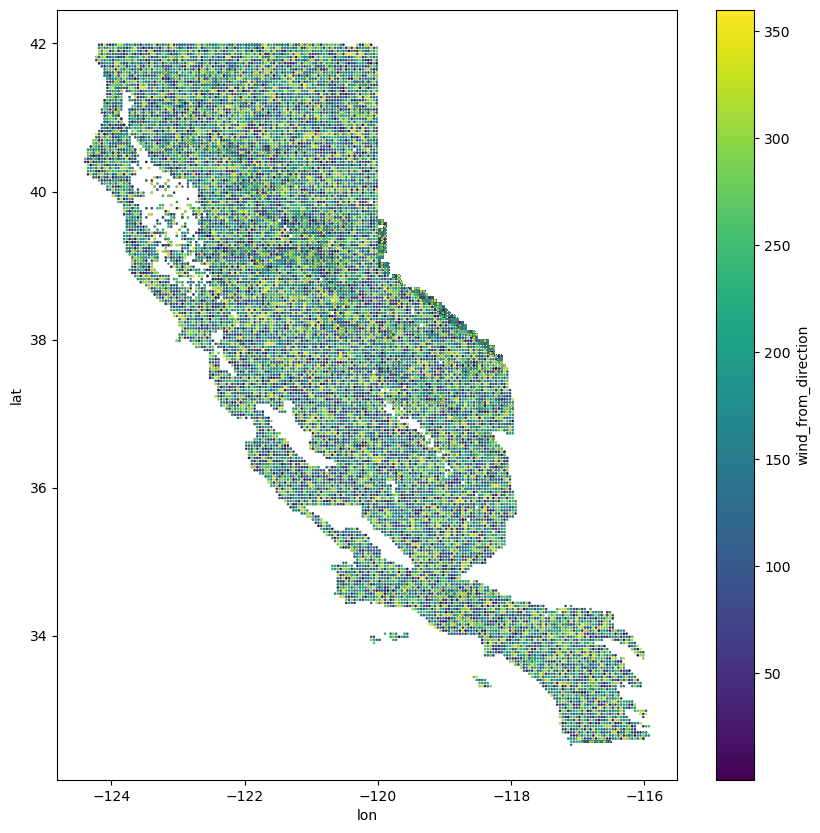

In [40]:
missing_dat.plot(kind='scatter', x='lon', y='lat', c='wind_from_direction', cmap='viridis', s=0.5, figsize=(10, 10))
plt.show()

In [ ]:
# write it back to parquet file
output_file = f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020_FillNA.parquet'
all_features.to_parquet(output_file)